In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Bidirectional, Concatenate, Attention, TimeDistributed,LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam

import numpy as np

In [ ]:
import json

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [ ]:
from tensorflow.keras.callbacks import Callback

In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
def get_glove_embeddings(path, word_index, embedding_dim=100):
    embeddings_index = {}
    with open(path, 'r', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector  # words not found in the embedding index will be all-zeros.
    return embedding_matrix


In [ ]:
def load_data(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

def preprocess_data(data):
    # Extract dialogues and preprocess
    inputs, targets = [], []

    for session_id, session in data.items():
        dialogue = session['dialogue']
        for i in range(len(dialogue) - 1):  # Ensure there's a following line to consider as a response
            if "Harry:" not in dialogue[i] and "Harry:" in dialogue[i + 1]:
                # Extract the line before Harry's response if Harry is not speaking in the current line
                input_line = dialogue[i]
                response_line = dialogue[i + 1]

                # Parse the lines to remove the speaker names
                input_text = input_line.split(': ', 1)[1] if ': ' in input_line else input_line
                response_text = response_line.split(': ', 1)[1] if ': ' in response_line else response_line

                # Append the preprocessed lines to the lists
                inputs.append(input_text)
                targets.append('<start>' + response_text + '<end>')

    #print("Sample input with tokens:", inputs[0]
    #print("Sample target with tokens:", targets[0])
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(inputs + targets)
    if '<start>' not in tokenizer.word_index:
        tokenizer.word_index['<start>'] = len(tokenizer.word_index) + 1
    if '<end>' not in tokenizer.word_index:
        tokenizer.word_index['<end>'] = len(tokenizer.word_index) + 1
    print("Index of '<start>':", tokenizer.word_index.get('<start>'))
    print("Index of '<end>':", tokenizer.word_index.get('<end>'))
    input_seqs = tokenizer.texts_to_sequences(inputs)
    target_seqs = tokenizer.texts_to_sequences(targets)
    max_len = max(max([len(seq) for seq in input_seqs]), max([len(seq) for seq in target_seqs]))
    encoder_input_data = pad_sequences(input_seqs, maxlen=max_len, padding='post')
    decoder_input_data = pad_sequences(target_seqs, maxlen=max_len, padding='post')

    num_classes = len(tokenizer.word_index) + 1
    # One-hot encode the target sequences
    decoder_target_data = np.zeros((len(decoder_input_data), max_len, num_classes), dtype='float32')
    for i in range(len(decoder_input_data)):
        for j in range(max_len):
            if j < len(decoder_input_data[i]):
                decoder_target_data[i, j, decoder_input_data[i][j]] = 1
    print("Shape of encoder input data:", encoder_input_data.shape)
    print("Shape of decoder input data:", decoder_input_data.shape)
    print("Shape of decoder target data:", decoder_target_data.shape)
    return encoder_input_data,decoder_input_data,decoder_target_data, tokenizer, max_len


In [ ]:
def preprocess_data_inference(data,tokenizer):
    # Extract dialogues and preprocess
    inputs, targets = [], []

    for session_id, session in data.items():
        dialogue = session['dialogue']
        for i in range(len(dialogue) - 1):  # Ensure there's a following line to consider as a response
            if "Harry:" not in dialogue[i] and "Harry:" in dialogue[i + 1]:
                # Extract the line before Harry's response if Harry is not speaking in the current line
                input_line = dialogue[i]
                response_line = dialogue[i + 1]

                # Parse the lines to remove the speaker names
                input_text = input_line.split(': ', 1)[1] if ': ' in input_line else input_line
                response_text = response_line.split(': ', 1)[1] if ': ' in response_line else response_line

                # Append the preprocessed lines to the lists
                inputs.append(input_text)
                targets.append('<start>' + response_text + '<end>')


    input_seqs = tokenizer.texts_to_sequences(inputs)
    target_seqs = tokenizer.texts_to_sequences(targets)
    max_len = max(max([len(seq) for seq in input_seqs]), max([len(seq) for seq in target_seqs]))
    encoder_input_data = pad_sequences(input_seqs, maxlen=max_len, padding='post')
    decoder_input_data = pad_sequences(target_seqs, maxlen=max_len, padding='post')

    num_classes = len(tokenizer.word_index) + 1
    # One-hot encode the target sequences
    decoder_target_data = np.zeros((len(decoder_input_data), max_len, num_classes), dtype='float32')
    for i in range(len(decoder_input_data)):
        for j in range(max_len):
            if j < len(decoder_input_data[i]):
                decoder_target_data[i, j, decoder_input_data[i][j]] = 1
    print("Shape of encoder input data:", encoder_input_data.shape)
    print("Shape of decoder input data:", decoder_input_data.shape)
    print("Shape of decoder target data:", decoder_target_data.shape)

    return encoder_input_data,decoder_input_data,decoder_target_data, max_len

In [ ]:
def create_dataset(encoder_input_data, decoder_input_data, decoder_target_data, batch_size=64):
    # Create a TensorFlow dataset object
    dataset = tf.data.Dataset.from_tensor_slices((
        {"encoder_inputs": encoder_input_data, "decoder_inputs": decoder_input_data},
        decoder_target_data
    ))

    # Cache the dataset, shuffle, batch, and prefetch to improve performance
    dataset = dataset.cache()
    dataset = dataset.shuffle(buffer_size=len(encoder_input_data))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    return dataset

In [ ]:
def build_model(vocab_size, max_len, embedding_matrix):
    # Encoder
    encoder_inputs = Input(shape=(None,),name = 'encoder_inputs')
    encoder_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_matrix.shape[1], weights=[embedding_matrix], trainable=False)(encoder_inputs)

    # Two BiLSTM Encoder layers
    encoder_bilstm1 = Bidirectional(LSTM(128, return_sequences=True, return_state=True, dropout=0.2))
    encoder_outputs1, forward_h1, forward_c1, backward_h1, backward_c1 = encoder_bilstm1(encoder_embedding)
    state_h1 = Concatenate()([forward_h1, backward_h1])
    state_c1 = Concatenate()([forward_c1, backward_c1])

    encoder_bilstm2 = Bidirectional(LSTM(128, return_sequences=True, return_state=True, dropout=0.2))
    encoder_outputs2, forward_h2, forward_c2, backward_h2, backward_c2 = encoder_bilstm2(encoder_outputs1)
    state_h2 = Concatenate()([forward_h2, backward_h2])
    state_c2 = Concatenate()([forward_c2, backward_c2])

    # Decoder
    decoder_inputs = Input(shape=(None,), name = 'decoder_inputs')
    decoder_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_matrix.shape[1], weights=[embedding_matrix], trainable=False)(decoder_inputs)
    decoder_lstm = LSTM(256, return_sequences=True, dropout=0.2)
    decoder_outputs = decoder_lstm(decoder_embedding, initial_state=[state_h2, state_c2])

    # Self-Attention Layer
    attention_layer = Attention()
    attention_result = attention_layer([decoder_outputs, encoder_outputs2])

    # Concatenate attention input and decoder LSTM output
    decoder_concat_input = Concatenate(axis=-1)([decoder_outputs, attention_result])
    decoder_concat_input = LayerNormalization()(decoder_concat_input)

    # Dense layer for output
    decoder_dense = TimeDistributed(Dense(vocab_size, activation='softmax'))
    decoder_outputs = decoder_dense(decoder_concat_input)

    # Model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
#training the model
train_path = '/content/drive/My Drive/en_train_set.json'
train_data = load_data(train_path)
encoder_input_data, decoder_input_data,decoder_target_data, tokenizer, max_sequence_len = preprocess_data(train_data)
train_encoder_input, val_encoder_input, train_decoder_input, val_decoder_input, train_decoder_target, val_decoder_target = train_test_split(
    encoder_input_data, decoder_input_data, decoder_target_data, test_size=0.2, random_state=13)
# Create training dataset
train_dataset = create_dataset(train_encoder_input, train_decoder_input, train_decoder_target, batch_size=8)

# Create validation dataset
val_dataset = create_dataset(val_encoder_input, val_decoder_input, val_decoder_target, batch_size=8)

Index of '<start>': 8005
Index of '<end>': 8006
Shape of encoder input data: (4372, 600)
Shape of decoder input data: (4372, 600)
Shape of decoder target data: (4372, 600, 8007)


In [ ]:
glove_path = '/content/drive/My Drive/glove.6B.100d.txt'
embedding_matrix = get_glove_embeddings(glove_path, tokenizer.word_index)

In [ ]:
model = build_model(len(tokenizer.word_index) + 1,max_sequence_len, embedding_matrix)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_inputs (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 embedding_4 (Embedding)     (None, None, 100)            800700    ['encoder_inputs[0][0]']      
                                                                                                  
 bidirectional_4 (Bidirecti  [(None, None, 256),          234496    ['embedding_4[0][0]']         
 onal)                        (None, 128),                                                        
                              (None, 128),                                                  

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
class BLEUScoreCallback(Callback):
    def __init__(self, tokenizer, encoder_input_train, decoder_target_train, encoder_input_val, decoder_target_val, max_len):
        super().__init__()
        self.tokenizer = tokenizer
        self.encoder_input_train = encoder_input_train
        self.decoder_target_train = decoder_target_train
        self.encoder_input_val = encoder_input_val
        self.decoder_target_val = decoder_target_val
        self.max_len = max_len
        self.start_token_index = tokenizer.word_index['<start>']
        self.end_token_index = tokenizer.word_index['<end>']

    def on_epoch_end(self, epoch, logs=None):
        train_bleu = self.calculate_bleu(self.encoder_input_train, self.decoder_target_train, 'Train')
        val_bleu = self.calculate_bleu(self.encoder_input_val, self.decoder_target_val, 'Validation')
        print(f'Epoch {epoch + 1}: Train BLEU Score = {train_bleu:.4f}, Validation BLEU Score = {val_bleu:.4f}')

    def calculate_bleu(self, encoder_input_data, decoder_target_data, data_type):
        total_bleu_score = 0
        num_samples = int(len(encoder_input_data)/10)
        sample_indices = np.random.choice(len(encoder_input_data), num_samples, replace=False)

        for idx in sample_indices:
            input_seq = encoder_input_data[idx:idx+1]  # Process one sequence at a time
            target_seq = [self.start_token_index]
            output_sentence = []

            for _ in range(self.max_len):
                target_seq_array = np.array([target_seq])
                predictions = self.model.predict([input_seq, target_seq_array])
                sampled_token_index = np.argmax(predictions[0, -1, :])

                if sampled_token_index == self.end_token_index:
                    break
                output_sentence.append(sampled_token_index)
                target_seq.append(sampled_token_index)

            # Convert sequences to text
            reference = self.tokenizer.sequences_to_texts([decoder_target_data[idx]])
            candidate = self.tokenizer.sequences_to_texts([output_sentence])
            bleu_score = sentence_bleu([reference[0].split()], candidate[0].split())
            total_bleu_score += bleu_score

        average_bleu_score = total_bleu_score / num_samples
        return average_bleu_score

In [ ]:
#bleu_callback = BLEUScoreCallback(tokenizer, train_encoder_input, train_decoder_target, val_encoder_input, val_decoder_target, max_sequence_len)
model_history = model.fit(train_dataset, epochs=5,validation_data = val_dataset,verbose=1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])

Epoch 1/5
55/55 [==============================] - 36s 522ms/step - loss: 0.8649 - accuracy: 0.9621 - val_loss: 0.1278 - val_accuracy: 0.9810
Epoch 2/5
55/55 [==============================] - 27s 491ms/step - loss: 0.1266 - accuracy: 0.9808 - val_loss: 0.1234 - val_accuracy: 0.9822
Epoch 3/5
55/55 [==============================] - 27s 491ms/step - loss: 0.1250 - accuracy: 0.9812 - val_loss: 0.1170 - val_accuracy: 0.9824
Epoch 4/5
55/55 [==============================] - 27s 492ms/step - loss: 0.1186 - accuracy: 0.9817 - val_loss: 0.1149 - val_accuracy: 0.9826
Epoch 5/5
55/55 [==============================] - 27s 492ms/step - loss: 0.1162 - accuracy: 0.9819 - val_loss: 0.1134 - val_accuracy: 0.9829


In [ ]:
# prompt: write a code to save the model weights in the drive

model.save_weights('/content/drive/MyDrive/model_glove_bilstm_weights.h5')


Text(0.5, 1.0, 'Loss Over Epochs')

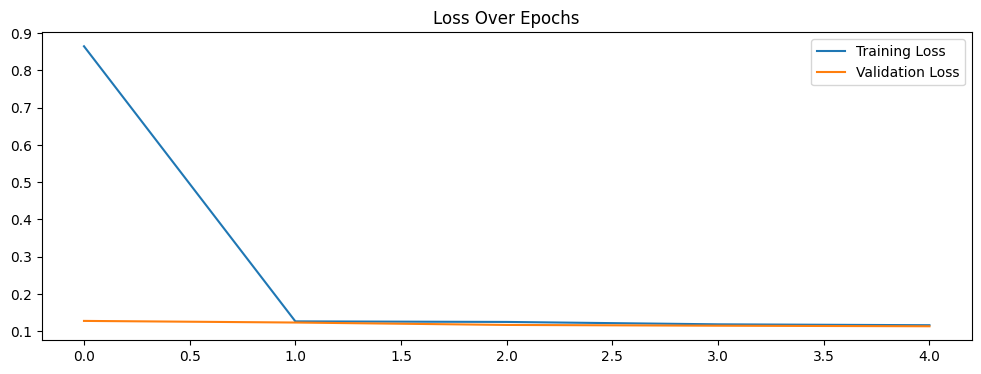

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 1, 1)
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')

# plt.subplot(1, 2, 2)
# plt.plot(model_history.history['accuracy'], label='Training Accuracy')  # Change 'accuracy' as per your metrics
# plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
# plt.legend()
# plt.title('Accuracy Over Epochs')

# plt.show()


In [ ]:
import time

In [ ]:
#evaluate the test dataset

In [ ]:
def generate_responses_and_evaluate_bleu(model, tokenizer, encoder_input_data, decoder_target_data, max_len, start_token_index, end_token_index):
    total_bleu_score = 0
    num_samples = int(len(encoder_input_data)/100)  # Use the entire dataset
    sample_indices = np.random.choice(len(encoder_input_data), num_samples, replace=False)

    total_time = 0
    response_times = []



    all_inputs = []
    all_references = []
    all_candidates = []

    for idx in sample_indices:
        input_seq = encoder_input_data[idx:idx+1]  # Extract one sequence for further processing
        input_text = tokenizer.sequences_to_texts(input_seq)[0]  # Convert the extracted sequence to text
        target_seq = [start_token_index]
        output_sentence = []

        start_time = time.time()
        print("sentence_started: ",input_text)
        print(input_text)
        print("Harry: ",end = ' ')
        for _ in range(max_len):
            target_seq_array = np.array([target_seq])
            predictions = model.predict([input_seq, target_seq_array],verbose = 0)
            sampled_token_index = np.argmax(predictions[0, -1, :])

            if sampled_token_index == end_token_index or len(target_seq) == max_len:
                break
            sampled_word = tokenizer.index_word[sampled_token_index] if sampled_token_index in tokenizer.index_word else ''
            print(sampled_word,end = ' ')  # Print each predicted word
            output_sentence.append(sampled_token_index)
            target_seq.append(sampled_token_index)

        print()

        elapsed_time = time.time() - start_time
        total_time += elapsed_time
        response_times.append(elapsed_time)
        print("time elapsed: ",elapsed_time)

        # Convert sequences to text
        reference = tokenizer.sequences_to_texts([decoder_target_data[idx]])
        candidate = tokenizer.sequences_to_texts([output_sentence])

        all_inputs.append(input_text[0].split())
        all_references.append(reference[0].split())
        all_candidates.append(candidate[0].split())

        # Calculate individual BLEU score
        bleu_score = sentence_bleu([reference[0].split()], candidate[0].split())
        total_bleu_score += bleu_score

        # print("Input Sentence:", input_text)
        # print("Model Output:", candidate)
        # print("Reference Sentence:", reference)
        # print("---" * 10)  # Separator for readability
        print("sentence_finished")


    average_bleu_score = total_bleu_score / num_samples
    average_response_time = sum(response_times) / num_samples

    return all_inputs,all_references,all_candidates,response_times,average_bleu_score,average_response_time


In [ ]:
test_data = load_data('/content/drive/My Drive/en_test_set.json')
encoder_input_data, decoder_input_data, decoder_target_data, max_len = preprocess_data_inference(test_data,tokenizer)

In [ ]:
def generate_responses(model, tokenizer, encoder_input_data, max_len, start_token_index, end_token_index):
    num_samples = len(encoder_input_data)# Reduce the dataset for quicker response times
    sample_indices = np.random.choice(len(encoder_input_data), num_samples, replace=False)

    total_time = 0
    response_times = []

    for idx in sample_indices:
        input_seq = encoder_input_data[idx:idx+1]  # Extract one sequence for further processing
        input_text = tokenizer.sequences_to_texts(input_seq)[0]  # Convert the extracted sequence to text

        print("Input: ", input_text)
        print("Harry: ", end=' ')

        target_seq = [start_token_index]
        output_sentence = []

        start_time = time.time()

        while len(target_seq) < max_len:
            target_seq_array = np.array([target_seq])
            predictions = model.predict([input_seq, target_seq_array], verbose=0)
            sampled_token_index = np.argmax(predictions[0, -1, :])

            if sampled_token_index == end_token_index or len(target_seq) == max_len:
                break

            sampled_word = tokenizer.index_word.get(sampled_token_index, '')
            print(sampled_word, end=' ')  # Print each predicted word on the same line
            output_sentence.append(sampled_token_index)
            target_seq.append(sampled_token_index)

        print()  # New line after the end of response

        elapsed_time = time.time() - start_time
        total_time += elapsed_time
        response_times.append(elapsed_time)

        print("Time elapsed for response: {:.4f} seconds".format(elapsed_time))
        print("---" * 20)  # Separator for readability

    average_response_time = total_time / num_samples

    return average_response_time, num_samples


In [ ]:
# Usage example
average_response_time, num_samples = generate_responses(
    model, tokenizer, encoder_input_data, 100,
    tokenizer.word_index['<start>'], tokenizer.word_index['<end>']
)
print("Processed {} sentences with an average response time of {:.4f} seconds.".format(num_samples, average_response_time))

Input:  are you all right you look awful
Harry:  i end                                                                                                  
Time elapsed for response: 10.9827 seconds
------------------------------------------------------------
Input:  nah that just one of those things you tell kids to teach them lessons isn’t it ‘don’t go looking for trouble don’t pick fights don’t go messing around with stuff that’s best left alone just keep your head down mind your own business and you’ll be okay ’ come to think of it maybe that why elder wands are supposed to be unlucky
Harry:  i end                                                                                                  
Time elapsed for response: 7.3497 seconds
------------------------------------------------------------
Input:  good afternoon
Harry:  i end                                                                                                  
Time elapsed for response: 7.3134 seconds
---------------

KeyboardInterrupt: 

In [ ]:
test_inputs,test_references,test_candidates,test_times,bleu_score,avg_time = generate_responses_and_evaluate_bleu(
    model, tokenizer, encoder_input_data, decoder_target_data, max_len,
    tokenizer.word_index['<start>'], tokenizer.word_index['<end>']
)

sentence_started:  gone
gone
Harry:  yeah end                                                                                                                                                                                                                   
time elapsed:  19.294798374176025
sentence_finished
sentence_started:  third time this week if you can’t control that owl it’ll have to go
third time this week if you can’t control that owl it’ll have to go
Harry:  yeah 

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

end                                                                                                                                                                                                                   
time elapsed:  15.826366424560547
sentence_finished


In [ ]:
for i in range(min(len(train_decoder_target), 100)):  # Ensure not to exceed the length of the data or 100 items
    # Ensure we pass a list of sequences, even if it's a list with only one sequence
    sequence_text = tokenizer.sequences_to_texts([val_decoder_target[i]])
    print(sequence_text)  # This will print the list containing the text representation of the i-th sequence


['where is it now end']
['what about dumbledore hagrid end']
['“what ” end']
['yeah i do malfoy’s father’s in azkaban don’t you think malfoy’d like revenge end']
['fleur didn’t turn up i couldn’t leave her end']
['but if voldemort’s trying to recruit more death eaters it’s bound to get out that he’s come back isn’t it end']
['there were witnesses who saw pettigrew die a whole street full of them end']
['oh i dunno let’s say i dreamed i was drowning snape in my cauldron yeah that’ll do end']
['yeah i expect that’s what mcgonagall will say when i ask for permission end']
['less than zero better try though hadn’t i i’ll offer to do two more detentions or something i dunno i hope she doesn’t keep me too long this evening you realize we’ve got to write three essays practice vanishing spells for mcgonagall work out a countercharm for flitwick finish the bowtruckle drawing and start that stupid dream diary for trelawney end']
['fortuna major end']
['“well hurry up i can’t breathe ” end']
['wh

In [ ]:
for i in range(len(test_inputs)):
    print("Input Sentence:", test_inputs[i])
    print("Model Output:", test_candidates[i])
    print("Reference Sentence:", test_references[i])
    print("Response time:",test_times[i])
    print("---" * 10)

In [ ]:
print(f"Average BLEU Score: {bleu_score}")
print(f"Average Response Time: {avg_time} seconds")

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
test_data = load_data('/content/drive/My Drive/en_test_set.json')

In [ ]:
#extract harry dialogues
def extract_harry_dialogues(data):

    conversations = []

    # Iterate through each session
    for session_id, session in data.items():
        dialogue = session['dialogue']
        for i in range(len(dialogue) - 1):  # Ensure there's a following line to consider as a response
            if "Harry:" not in dialogue[i] and "Harry:" in dialogue[i + 1]:
                # Extract the line before Harry's response if Harry is not speaking in the current line
                input_line = dialogue[i]
                response_line = dialogue[i + 1]

                # Parse the lines to remove the speaker names
                input_text = input_line.split(': ', 1)[1] if ': ' in input_line else input_line
                response_text = response_line.split(': ', 1)[1] if ': ' in response_line else response_line

                # Store the dialogues as tuples of (input, response)
                conversations.append((input_text, response_text))

    return conversations

# Call the function with the path to your JSON file
dialogues = extract_harry_dialogues(data)

# Example output
for input_text, response_text in dialogues[:10]:  # Print first 5 dialogues for example
    print("Input:", input_text)
    print("Response:", response_text)
    print("------")

Input: Up! Get up! Now! Up! Up! Are you up yet?
Response: Nearly,
------
Input: Well, get a move on, I want you to look after the bacon. What did you say?
Response: Nothing, nothing . . .
------
Input: On vacation in Majorca,
Response: You could just leave me here,
------
Input: And come back and find the house in ruins? 
Response: I won’t blow up the house,
------
Input: . . . roaring along like maniacs, the young hoodlums,
Response: I had a dream about a motorcycle, It was flying.
------
Input: MOTORCYCLES DON’T FLY!
Response: I know they don’t, It was only a dream.
------
Input: Your new school uniform,
Response: Oh, I didn’t realize it had to be so wet.
------
Input: Make Harry get it.
Response: Make Dudley get it.
------
Input: Poke him with your Smelting stick,
Response: That’s mine!
------
Input: I want to read that letter,
Response: I want to read it, as it’s mine.
------
